### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [2]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [8]:
from __future__ import annotations

from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
            self,
            base_model_params: dict = None,
            n_estimators: int = 10,
            learning_rate: float = 0.1,
            subsample: float = 0.3,
            early_stopping_rounds: int = None,
            plot: bool = False,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)

        self.plot: bool = plot

        self.history = defaultdict(list)

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def fit_new_base_model(self, x, y, predictions):
        """
        Обучает новую базовую модель и добавляет ее в ансамбль.

        Параметры
        ----------
        x : array-like, форма (n_samples, n_features)
            Массив признаков для набора данных.
        y : array-like, форма (n_samples,)
            Массив целевых значений.
        predictions : array-like, форма (n_samples,)
            Предсказания текущего ансамбля.

        Примечания
        ----------
        Эта функция добавляет новую модель и обновляет ансамбль.
        """
        weights = np.exp(self.loss_derivative(y, predictions))
        weights /= np.sum(weights)

        sampled_indices = np.random.choice(x.shape[0], size=int(self.subsample*x.shape[0]), replace=False, p=weights)
        sampled_x, sampled_y = x[sampled_indices], y[sampled_indices]

        model = self.base_model_class(**self.base_model_params)
        model.fit(sampled_x, sampled_y)

        new_predictions = model.predict(x)
        gamma = self.find_optimal_gamma(y, predictions, new_predictions)

        self.gammas.append(gamma)
        self.models.append(model)

    def fit(self, x_train, y_train, x_valid, y_valid):
        """
        Обучает модель на тренировочном наборе данных и выполняет валидацию на валидационном наборе.

        Параметры
        ----------
        x_train : array-like, форма (n_samples, n_features)
            Массив признаков для тренировочного набора.
        y_train : array-like, форма (n_samples,)
            Массив целевых значений для тренировочного набора.
        x_valid : array-like, форма (n_samples, n_features)
            Массив признаков для валидационного набора.
        y_valid : array-like, форма (n_samples,)
            Массив целевых значений для валидационного набора.
        """
        train_predictions = np.zeros(y_train.shape[0])
        valid_predictions = np.zeros(y_valid.shape[0])

        for _ in range(self.n_estimators):
            self.fit_new_base_model(x_train, y_train, train_predictions)
            train_predictions += self.learning_rate * self.gammas[-1] * np.array([model.predict(x_train) for model in self.models]).sum(axis=0)
            valid_predictions += self.learning_rate * self.gammas[-1] * np.array([model.predict(x_valid) for model in self.models]).sum(axis=0)

            if self.early_stopping_rounds is not None:
                self.validation_loss[:-1] = self.validation_loss[1:]
                self.validation_loss[-1] = self.loss_fn(y_valid, valid_predictions)
                if np.all(self.validation_loss[:-1] <= self.validation_loss[-1]):
                    break

        if self.plot:
            pass

    def predict_proba(self, x):
        """
        Вычисляет вероятности принадлежности классу для каждого образца.

        Параметры
        ----------
        x : array-like, форма (n_samples, n_features)
            Массив признаков для набора данных.

        Возвращает
        ----------
        probabilities : array-like, форма (n_samples, n_classes)
            Вероятности для каждого класса.
        """
        predictions = np.zeros(x.shape[0])
        for gamma, model in zip(self.gammas, self.models):
            predictions += self.learning_rate * gamma * model.predict(x)
        probabilities = self.sigmoid(predictions)
        return np.vstack((1-probabilities, probabilities)).T

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        """
        Находит оптимальное значение гаммы для минимизации функции потерь.

        Параметры
        ----------
        y : array-like, форма (n_samples,)
            Целевые значения.
        old_predictions : array-like, форма (n_samples,)
            Предыдущие предсказания ансамбля.
        new_predictions : array-like, форма (n_samples,)
            Новые предсказания базовой модели.

        Возвращает
        ----------
        gamma : float
            Оптимальное значение гаммы.

        Примечания
        ----------
        Значение гаммы определяется путем минимизации функции потерь.
        """
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]

        return gammas[np.argmin(losses)]

    def score(self, x, y):
        return score(self, x, y)

    @property
    def feature_importances_(self):
        """
        Возвращает важность признаков в обученной модели.

        Возвращает
        ----------
        importances : array-like, форма (n_features,)
            Важность каждого признака.

        Примечания
        ----------
        Важность признаков определяется по вкладу каждого признака в финальную модель.
        """
        importances = np.zeros(x.shape[1])
        for model in self.models:
            importances += model.feature_importances_
        return importances / len(self.models)


In [10]:
boosting = Boosting()

boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

Train ROC-AUC 0.9869
Valid ROC-AUC 0.9457
Test ROC-AUC 0.9466


In [7]:
% load_ext autoreload

UsageError: Line magic function `%` not found.


In [4]:
% autoreload 2

from boosting import Boosting

UsageError: Line magic function `%` not found.


### Проверка кода

У автора задания всё учится около одной секунды.

In [6]:
boosting = Boosting()

% time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

NameError: name 'Boosting' is not defined

## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

Max depth: 1, ROC-AUC для train: 0.8401, ROC-AUC для test: 0.8396
Max depth: 3, ROC-AUC для train: 0.9297, ROC-AUC для test: 0.9275
Max depth: 5, ROC-AUC для train: 0.9480, ROC-AUC для test: 0.9432
Max depth: 7, ROC-AUC для train: 0.9605, ROC-AUC для test: 0.9523
Max depth: 9, ROC-AUC для train: 0.9684, ROC-AUC для test: 0.9556
Max depth: 11, ROC-AUC для train: 0.9742, ROC-AUC для test: 0.9540
Max depth: 13, ROC-AUC для train: 0.9785, ROC-AUC для test: 0.9529
Max depth: 15, ROC-AUC для train: 0.9819, ROC-AUC для test: 0.9494
Max depth: 17, ROC-AUC для train: 0.9833, ROC-AUC для test: 0.9491
Max depth: 19, ROC-AUC для train: 0.9859, ROC-AUC для test: 0.9475
Max depth: 21, ROC-AUC для train: 0.9861, ROC-AUC для test: 0.9503
Max depth: 23, ROC-AUC для train: 0.9862, ROC-AUC для test: 0.9493
Max depth: 25, ROC-AUC для train: 0.9872, ROC-AUC для test: 0.9485
Max depth: 27, ROC-AUC для train: 0.9872, ROC-AUC для test: 0.9469
Max depth: 29, ROC-AUC для train: 0.9880, ROC-AUC для test: 0.9495


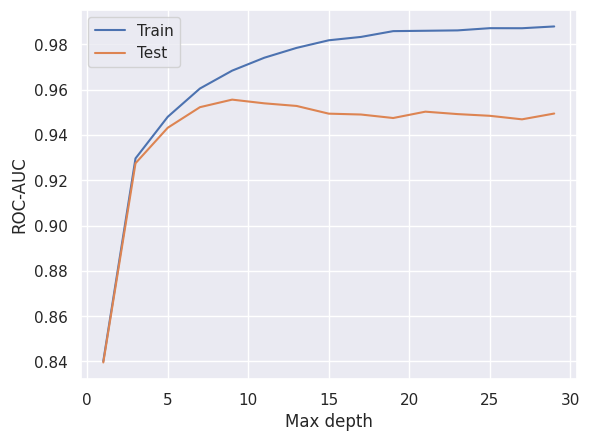

In [13]:
results = {}

depths = range(1, 30, 2)

train_scores = []
test_scores = []

for max_depth in depths:
    clf = Boosting(base_model_params={'max_depth': max_depth})

    clf.fit(x_train, y_train, x_valid, y_valid)

    train_score = roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1])
    test_score = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])

    train_scores.append(train_score)
    test_scores.append(test_score)

    print(f'Max depth: {max_depth}, ROC-AUC для train: {train_score:.4f}, ROC-AUC для test: {test_score:.4f}')

plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.xlabel('Max depth')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Видно, что модель с глубиной дерева 9 имеет лучшее качество на тестовой выборке. Вероятно, более глубокие деревья приводят к переобучению. С другой стороны, деревья меньшей глубины могут недообучаются

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [15]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [16]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 16, 256)
    max_depth = trial.suggest_int('max_depth', -1, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-5, 1e-1)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-5, 1e-1)

    dtrain = lgb.Dataset(x_train, label=y_train)
    model = lgb.train(
        params={
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'num_leaves': num_leaves,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'n_estimators': n_estimators,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
        },
        train_set=dtrain,
    )

    dval = lgb.Dataset(x_test, label=y_test)
    y_pred = model.predict(x_test, num_iteration=model.best_iteration)
    score = roc_auc_score(y_test, y_pred)

    return score

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print('Best params:', best_params)

[I 2024-05-22 20:20:21,589] A new study created in memory with name: no-name-cb4de866-2ae2-4688-b3ac-a32312a7cba9


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:20:37,214] Trial 0 finished with value: 0.9642654173293027 and parameters: {'num_leaves': 106, 'max_depth': 10, 'learning_rate': 0.008471801418819975, 'n_estimators': 603, 'subsample': 0.24041677639819287, 'colsample_bytree': 0.2403950683025824, 'reg_alpha': 1.7073967431528103e-05, 'reg_lambda': 0.029154431891537533}. Best is trial 0 with value: 0.9642654173293027.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:20:59,547] Trial 1 finished with value: 0.9563058265796206 and parameters: {'num_leaves': 160, 'max_depth': 7, 'learning_rate': 1.2087541473056957e-05, 'n_estimators': 971, 'subsample': 0.8491983767203796, 'colsample_bytree': 0.29110519961044856, 'reg_alpha': 5.3370327626039544e-05, 'reg_lambda': 5.415244119402538e-05}. Best is trial 0 with value: 0.9642654173293027.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:00,208] Trial 2 finished with value: 0.9503448890671837 and parameters: {'num_leaves': 89, 'max_depth': 5, 'learning_rate': 0.0005342937261279777, 'n_estimators': 298, 'subsample': 0.6506676052501416, 'colsample_bytree': 0.22554447458683766, 'reg_alpha': 0.00014742753159914678, 'reg_lambda': 0.0002920433847181409}. Best is trial 0 with value: 0.9642654173293027.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:01,677] Trial 3 finished with value: 0.9497232450296336 and parameters: {'num_leaves': 125, 'max_depth': 8, 'learning_rate': 6.290644294586152e-05, 'n_estimators': 519, 'subsample': 0.6331731119758383, 'colsample_bytree': 0.14180537144799796, 'reg_alpha': 0.0026926469100861782, 'reg_lambda': 4.809461967501571e-05}. Best is trial 0 with value: 0.9642654173293027.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-05-22 20:21:03,535] Trial 4 finished with value: 0.9672478759832084 and parameters: {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.07286653737491042, 'n_estimators': 811, 'subsample': 0.3741523922560336, 'colsample_bytree': 0.1879049026057455, 'reg_alpha': 0.005456725485601475, 'reg_lambda': 0.00057624872164786}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:05,643] Trial 5 finished with value: 0.9444965797638549 and parameters: {'num_leaves': 45, 'max_depth': 4, 'learning_rate': 1.3726318898045866e-05, 'n_estimators': 911, 'subsample': 0.3329019834400152, 'colsample_bytree': 0.6962700559185838, 'reg_alpha': 0.00017654048052495074, 'reg_lambda': 0.0012030178871154666}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:21:06,311] Trial 6 finished with value: 0.9607950357624413 and parameters: {'num_leaves': 147, 'max_depth': 1, 'learning_rate': 0.07556810141274425, 'n_estimators': 778, 'subsample': 0.9455490474077702, 'colsample_bytree': 0.905344615384884, 'reg_alpha': 0.002463768595899745, 'reg_lambda': 0.04869640941520897}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:21:06,634] Trial 7 finished with value: 0.9119108111937317 and parameters: {'num_leaves': 37, 'max_depth': 1, 'learning_rate': 1.5167330688076188e-05, 'n_estimators': 332, 'subsample': 0.4498095607205338, 'colsample_bytree': 0.34421412859650635, 'reg_alpha': 0.02065142557895925, 'reg_lambda': 0.00026730883107816685}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:11,759] Trial 8 finished with value: 0.9410369436445056 and parameters: {'num_leaves': 83, 'max_depth': 5, 'learning_rate': 3.661819220392426e-05, 'n_estimators': 804, 'subsample': 0.16709557931179375, 'colsample_bytree': 0.9881982429404655, 'reg_alpha': 0.012273800987852962, 'reg_lambda': 6.235377135673157e-05}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:13,245] Trial 9 finished with value: 0.9609478599048351 and parameters: {'num_leaves': 17, 'max_depth': 8, 'learning_rate': 0.00672093005015611, 'n_estimators': 732, 'subsample': 0.7941433120173511, 'colsample_bytree': 0.16664018656068133, 'reg_alpha': 0.00027155819552829395, 'reg_lambda': 2.9072088906598435e-05}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:13,530] Trial 10 finished with value: 0.9630611312488757 and parameters: {'num_leaves': 243, 'max_depth': 10, 'learning_rate': 0.07553503645583182, 'n_estimators': 27, 'subsample': 0.45748816872801584, 'colsample_bytree': 0.5106948164203384, 'reg_alpha': 0.06903717055434683, 'reg_lambda': 0.005084983159628163}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:17,132] Trial 11 finished with value: 0.9662457635078234 and parameters: {'num_leaves': 204, 'max_depth': 10, 'learning_rate': 0.009905000310174335, 'n_estimators': 597, 'subsample': 0.11925599355234749, 'colsample_bytree': 0.43343907217303185, 'reg_alpha': 1.8675879840826396e-05, 'reg_lambda': 0.05709803765638015}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:21,109] Trial 12 finished with value: 0.9665275330203623 and parameters: {'num_leaves': 202, 'max_depth': 10, 'learning_rate': 0.01143728176319708, 'n_estimators': 628, 'subsample': 0.16290322526006515, 'colsample_bytree': 0.416005972264224, 'reg_alpha': 0.0008469160327049815, 'reg_lambda': 0.005606214379891436}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:26,870] Trial 13 finished with value: 0.9656806325645961 and parameters: {'num_leaves': 196, 'max_depth': -1, 'learning_rate': 0.023331389095634376, 'n_estimators': 349, 'subsample': 0.31948746477721135, 'colsample_bytree': 0.6436759142706434, 'reg_alpha': 0.001809172804197627, 'reg_lambda': 0.0051029588074428854}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:29,832] Trial 14 finished with value: 0.9601849331314781 and parameters: {'num_leaves': 234, 'max_depth': 7, 'learning_rate': 0.0014670533987122102, 'n_estimators': 689, 'subsample': 0.384584011659395, 'colsample_bytree': 0.4276322023016095, 'reg_alpha': 0.0007054382978969138, 'reg_lambda': 0.0029474374285116778}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:34,778] Trial 15 finished with value: 0.9611985870134502 and parameters: {'num_leaves': 177, 'max_depth': 8, 'learning_rate': 0.0017186772653901372, 'n_estimators': 876, 'subsample': 0.23315195892810767, 'colsample_bytree': 0.6095135203704667, 'reg_alpha': 0.00984355051376365, 'reg_lambda': 0.01508625542422027}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:40,010] Trial 16 finished with value: 0.9665203693886875 and parameters: {'num_leaves': 210, 'max_depth': 9, 'learning_rate': 0.021854811098168933, 'n_estimators': 469, 'subsample': 0.5367891141375514, 'colsample_bytree': 0.753043882253781, 'reg_alpha': 0.0005131956270418475, 'reg_lambda': 0.00046564928420265647}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:42,305] Trial 17 finished with value: 0.9555397159699638 and parameters: {'num_leaves': 68, 'max_depth': 6, 'learning_rate': 0.0002472961497717191, 'n_estimators': 656, 'subsample': 0.10052707853486577, 'colsample_bytree': 0.37573139968028285, 'reg_alpha': 0.00525792104953392, 'reg_lambda': 0.001348865748465135}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:42,651] Trial 18 finished with value: 0.9503198163563222 and parameters: {'num_leaves': 121, 'max_depth': 4, 'learning_rate': 0.002958086401522234, 'n_estimators': 134, 'subsample': 0.25079309307905484, 'colsample_bytree': 0.5223109666615595, 'reg_alpha': 0.040575879851653125, 'reg_lambda': 0.01231287694602281}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:43,295] Trial 19 finished with value: 0.9602326906759762 and parameters: {'num_leaves': 256, 'max_depth': 2, 'learning_rate': 0.03623522902311865, 'n_estimators': 475, 'subsample': 0.41746236758834326, 'colsample_bytree': 0.12187806622358904, 'reg_alpha': 0.0011209564715035974, 'reg_lambda': 0.00011115207411534468}. Best is trial 4 with value: 0.9672478759832084.



[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-05-22 20:21:47,411] Trial 20 finished with value: 0.964809853336581 and parameters: {'num_leaves': 173, 'max_depth': 9, 'learning_rate': 0.005123696943597166, 'n_estimators': 857, 'subsample': 0.5946204438364249, 'colsample_bytree': 0.3019463396868903, 'reg_alpha': 0.005736422846596355, 'reg_lambda': 0.0021324738413770992}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:49,974] Trial 21 finished with value: 0.9665339006929619 and parameters: {'num_leaves': 216, 'max_depth': 9, 'learning_rate': 0.021623449345391003, 'n_estimators': 459, 'subsample': 0.566942848737959, 'colsample_bytree': 0.7547835364105744, 'reg_alpha': 0.00041368999427323467, 'reg_lambda': 0.0004325180977713662}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:54,944] Trial 22 finished with value: 0.9626269355734806 and parameters: {'num_leaves': 224, 'max_depth': 9, 'learning_rate': 0.0944867998440012, 'n_estimators': 530, 'subsample': 0.7161503421193317, 'colsample_bytree': 0.8122584252665408, 'reg_alpha': 0.0004071544342265283, 'reg_lambda': 0.0005684702873576847}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:57,469] Trial 23 finished with value: 0.9663564018192441 and parameters: {'num_leaves': 185, 'max_depth': 10, 'learning_rate': 0.019615563840351166, 'n_estimators': 405, 'subsample': 0.5020963564748037, 'colsample_bytree': 0.5680886434790026, 'reg_alpha': 0.0010034601545082353, 'reg_lambda': 0.00011963693800775367}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:21:58,408] Trial 24 finished with value: 0.9667082157303799 and parameters: {'num_leaves': 157, 'max_depth': 7, 'learning_rate': 0.04269088125644443, 'n_estimators': 228, 'subsample': 0.33136358343467975, 'colsample_bytree': 0.45881175979044225, 'reg_alpha': 8.016447694518476e-05, 'reg_lambda': 0.0008256196583740895}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:21:59,166] Trial 25 finished with value: 0.9655584528465884 and parameters: {'num_leaves': 148, 'max_depth': 7, 'learning_rate': 0.040253573714793836, 'n_estimators': 165, 'subsample': 0.37724616705934777, 'colsample_bytree': 0.8171357910412851, 'reg_alpha': 7.107522934551695e-05, 'reg_lambda': 1.1969062590495653e-05}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:00,145] Trial 26 finished with value: 0.9668821327882605 and parameters: {'num_leaves': 109, 'max_depth': 6, 'learning_rate': 0.041446499926807503, 'n_estimators': 275, 'subsample': 0.5138395822067511, 'colsample_bytree': 0.6901256049533453, 'reg_alpha': 5.469318910580821e-05, 'reg_lambda': 0.000865480142387571}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:00,841] Trial 27 finished with value: 0.9665418602837116 and parameters: {'num_leaves': 64, 'max_depth': 6, 'learning_rate': 0.04770456052369031, 'n_estimators': 210, 'subsample': 0.3161286906299361, 'colsample_bytree': 0.4987604261521053, 'reg_alpha': 4.9968154586200476e-05, 'reg_lambda': 0.0008388230141970088}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-22 20:22:01,329] Trial 28 finished with value: 0.942726764760663 and parameters: {'num_leaves': 109, 'max_depth': 3, 'learning_rate': 0.003255688175893387, 'n_estimators': 261, 'subsample': 0.48866087435666755, 'colsample_bytree': 0.6704090552011632, 'reg_alpha': 1.0670851043897344e-05, 'reg_lambda': 0.0001910401694922605}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-05-22 20:22:01,538] Trial 29 finished with value: 0.926219767484435 and parameters: {'num_leaves': 96, 'max_depth': 6, 'learning_rate': 0.0005044182180223151, 'n_estimators': 38, 'subsample': 0.2650166570105287, 'colsample_bytree': 0.2239215061851943, 'reg_alpha': 2.7127674655890185e-05, 'reg_lambda': 0.0020814023835953608}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:01,941] Trial 30 finished with value: 0.9629532787942175 and parameters: {'num_leaves': 24, 'max_depth': 5, 'learning_rate': 0.041388641011642774, 'n_estimators': 127, 'subsample': 0.7067889548609451, 'colsample_bytree': 0.5757545273958548, 'reg_alpha': 0.00011741198358204791, 'reg_lambda': 0.0008427441235293672}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2024-05-22 20:22:02,662] Trial 31 finished with value: 0.9665581774447484 and parameters: {'num_leaves': 57, 'max_depth': 6, 'learning_rate': 0.046757045824357496, 'n_estimators': 214, 'subsample': 0.3097622565028019, 'colsample_bytree': 0.4943177165605525, 'reg_alpha': 4.054511901786158e-05, 'reg_lambda': 0.0006829073787671446}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-22 20:22:03,377] Trial 32 finished with value: 0.9624060569301769 and parameters: {'num_leaves': 59, 'max_depth': 7, 'learning_rate': 0.011973362813066669, 'n_estimators': 203, 'subsample': 0.3559293895715675, 'colsample_bytree': 0.4778674492418463, 'reg_alpha': 2.4312690436357382e-05, 'reg_lambda': 0.0008096609224583161}. Best is trial 4 with value: 0.9672478759832084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:06,119] Trial 33 finished with value: 0.9677158999192897 and parameters: {'num_leaves': 42, 'max_depth': 6, 'learning_rate': 0.06561175378734103, 'n_estimators': 267, 'subsample': 0.21596078237217725, 'colsample_bytree': 0.30743691442652554, 'reg_alpha': 5.1042718576237105e-05, 'reg_lambda': 0.0002958845106110659}. Best is trial 33 with value: 0.9677158999192897.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

[I 2024-05-22 20:22:09,780] Trial 34 finished with value: 0.964880693694253 and parameters: {'num_leaves': 37, 'max_depth': 7, 'learning_rate': 0.09843155468624189, 'n_estimators': 999, 'subsample': 0.20406941723923222, 'colsample_bytree': 0.2792371792936934, 'reg_alpha': 7.653185177177074e-05, 'reg_lambda': 0.00023248792374630015}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:10,660] Trial 35 finished with value: 0.9607659832562049 and parameters: {'num_leaves': 76, 'max_depth': 4, 'learning_rate': 0.013695938160790793, 'n_estimators': 395, 'subsample': 0.41592312114771884, 'colsample_bytree': 0.1851378296645521, 'reg_alpha': 1.1757227171518717e-05, 'reg_lambda': 0.00014517659301663423}. Best is trial 33 with value: 0.9677158999192897.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-05-22 20:22:11,742] Trial 36 finished with value: 0.9666608561654194 and parameters: {'num_leaves': 139, 'max_depth': 8, 'learning_rate': 0.06337078502915051, 'n_estimators': 279, 'subsample': 0.2643362827477596, 'colsample_bytree': 0.2352090557439236, 'reg_alpha': 0.00013661636492661832, 'reg_lambda': 0.0017616485550707053}. Best is trial 33 with value: 0.9677158999192897.
[I 2024-05-22 20:22:12,021] Trial 37 finished with value: 0.959900377762177 and parameters: {'num_leaves': 162, 'max_depth': 5, 'learning_rate': 0.026270264590004287, 'n_estimators': 84, 'subsample': 0.525373418383519, 'colsample_bytree': 0.342635911937061, 'reg_alpha': 0.00023056701144494386, 'reg_lambda': 0.00028845658412847587}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:13,037] Trial 38 finished with value: 0.9491951261833923 and parameters: {'num_leaves': 102, 'max_depth': 3, 'learning_rate': 0.00557191082139076, 'n_estimators': 555, 'subsample': 0.6099405644378426, 'colsample_bytree': 0.10240116514955322, 'reg_alpha': 3.577579667103567e-05, 'reg_lambda': 7.0958962784657e-05}. Best is trial 33 with value: 0.9677158999192897.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-05-22 20:22:14,094] Trial 39 finished with value: 0.9542128521919917 and parameters: {'num_leaves': 48, 'max_depth': 6, 'learning_rate': 0.00014303586175398763, 'n_estimators': 319, 'subsample': 0.9818607442594255, 'colsample_bytree': 0.280333542018848, 'reg_alpha': 0.0001030403595705183, 'reg_lambda': 0.000358464999556725}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:15,603] Trial 40 finished with value: 0.9667766682108273 and parameters: {'num_leaves': 122, 'max_depth': 8, 'learning_rate': 0.06591286070080714, 'n_estimators': 386, 'subsample': 0.43279219933139224, 'colsample_bytree': 0.3479074775562569, 'reg_alpha': 0.00023620489426401554, 'reg_lambda': 3.263906431720564e-05}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:16,953] Trial 41 finished with value: 0.9669032257037472 and parameters: {'num_leaves': 121, 'max_depth': 8, 'learning_rate': 0.06511416934833147, 'n_estimators': 380, 'subsample': 0.45655224666020655, 'colsample_bytree': 0.3663486788065402, 'reg_alpha': 0.0002299361908410132, 'reg_lambda': 1.4777880758638605e-05}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:21,597] Trial 42 finished with value: 0.9669756579795693 and parameters: {'num_leaves': 117, 'max_depth': 8, 'learning_rate': 0.06306512120708484, 'n_estimators': 387, 'subsample': 0.46225078407621906, 'colsample_bytree': 0.3619957731234499, 'reg_alpha': 0.0002223845236185466, 'reg_lambda': 1.0357226635986009e-05}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:22,855] Trial 43 finished with value: 0.966635783454558 and parameters: {'num_leaves': 113, 'max_depth': 8, 'learning_rate': 0.06746911764354413, 'n_estimators': 347, 'subsample': 0.4810670251499442, 'colsample_bytree': 0.16510726595824238, 'reg_alpha': 0.00015465521061807988, 'reg_lambda': 1.1924506178160376e-05}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:24,585] Trial 44 finished with value: 0.9644142616763216 and parameters: {'num_leaves': 89, 'max_depth': 9, 'learning_rate': 0.09913395262289032, 'n_estimators': 441, 'subsample': 0.6493450694831228, 'colsample_bytree': 0.38603884626509855, 'reg_alpha': 0.0036821277257648964, 'reg_lambda': 1.5637762548072236e-05}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:25,820] Trial 45 finished with value: 0.9619762390296941 and parameters: {'num_leaves': 133, 'max_depth': 10, 'learning_rate': 0.015686030437659367, 'n_estimators': 277, 'subsample': 0.5586667594892354, 'colsample_bytree': 0.2048327106878925, 'reg_alpha': 0.0018283805228181808, 'reg_lambda': 2.3304206447538968e-05}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:27,374] Trial 46 finished with value: 0.9676172009939936 and parameters: {'num_leaves': 27, 'max_depth': 7, 'learning_rate': 0.03053995940275021, 'n_estimators': 582, 'subsample': 0.46019526415246786, 'colsample_bytree': 0.2987264047324972, 'reg_alpha': 0.00026265762882201314, 'reg_lambda': 4.850521816546654e-05}. Best is trial 33 with value: 0.9677158999192897.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:29,307] Trial 47 finished with value: 0.9677748008908376 and parameters: {'num_leaves': 26, 'max_depth': 7, 'learning_rate': 0.02813298470325685, 'n_estimators': 768, 'subsample': 0.3943522637676562, 'colsample_bytree': 0.3090774125709197, 'reg_alpha': 0.0003227086716065709, 'reg_lambda': 5.15090255986256e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:31,279] Trial 48 finished with value: 0.9655767599053127 and parameters: {'num_leaves': 26, 'max_depth': 7, 'learning_rate': 0.008238958310575214, 'n_estimators': 781, 'subsample': 0.3828573917713155, 'colsample_bytree': 0.3186926591703053, 'reg_alpha': 0.0006132622695740124, 'reg_lambda': 7.658772847606803e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:35,973] Trial 49 finished with value: 0.9673322476451549 and parameters: {'num_leaves': 38, 'max_depth': 5, 'learning_rate': 0.0299234130652323, 'n_estimators': 738, 'subsample': 0.18511916739102505, 'colsample_bytree': 0.24708657178703602, 'reg_alpha': 0.0003510972292332186, 'reg_lambda': 4.67642512032561e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:37,795] Trial 50 finished with value: 0.9673215021976431 and parameters: {'num_leaves': 40, 'max_depth': 5, 'learning_rate': 0.027813987274852618, 'n_estimators': 726, 'subsample': 0.1555535527991621, 'colsample_bytree': 0.2575183613356852, 'reg_alpha': 0.00035914948816639117, 'reg_lambda': 4.819871638247293e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:39,715] Trial 51 finished with value: 0.9671917608684232 and parameters: {'num_leaves': 39, 'max_depth': 5, 'learning_rate': 0.028299120398185953, 'n_estimators': 717, 'subsample': 0.16271815330297335, 'colsample_bytree': 0.2586487089193787, 'reg_alpha': 0.00034120687942507, 'reg_lambda': 4.072913847568048e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:41,397] Trial 52 finished with value: 0.9648484573517168 and parameters: {'num_leaves': 19, 'max_depth': 4, 'learning_rate': 0.018040415554167098, 'n_estimators': 805, 'subsample': 0.14498895440254522, 'colsample_bytree': 0.1452768089041538, 'reg_alpha': 0.0014771510932758886, 'reg_lambda': 5.7977059078667594e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:43,794] Trial 53 finished with value: 0.9674926333987612 and parameters: {'num_leaves': 49, 'max_depth': 5, 'learning_rate': 0.024864069430618533, 'n_estimators': 929, 'subsample': 0.2763163992213221, 'colsample_bytree': 0.23929903825943785, 'reg_alpha': 0.023070728373848753, 'reg_lambda': 2.531245326499343e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:45,082] Trial 54 finished with value: 0.9658887758627003 and parameters: {'num_leaves': 48, 'max_depth': 3, 'learning_rate': 0.031279809658070416, 'n_estimators': 746, 'subsample': 0.20536816722680684, 'colsample_bytree': 0.2589286371433388, 'reg_alpha': 0.0006136884935109778, 'reg_lambda': 2.16203574751979e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:51,008] Trial 55 finished with value: 0.9652997661472238 and parameters: {'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.0086383384391279, 'n_estimators': 928, 'subsample': 0.20170400468945457, 'colsample_bytree': 0.3040901098591615, 'reg_alpha': 0.029101890938289902, 'reg_lambda': 4.072983301924395e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:22:52,929] Trial 56 finished with value: 0.9674838778489365 and parameters: {'num_leaves': 17, 'max_depth': 4, 'learning_rate': 0.028585230658245205, 'n_estimators': 857, 'subsample': 0.2909533267793549, 'colsample_bytree': 0.3996919904040047, 'reg_alpha': 0.00033032796626507457, 'reg_lambda': 8.922203822537673e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:55,004] Trial 57 finished with value: 0.957670896393191 and parameters: {'num_leaves': 19, 'max_depth': 4, 'learning_rate': 0.0033801093012599775, 'n_estimators': 862, 'subsample': 0.2819449998716207, 'colsample_bytree': 0.4043773534201951, 'reg_alpha': 0.08963021413541944, 'reg_lambda': 7.74080672690655e-05}. Best is trial 47 with value: 0.9677748008908376.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:22:57,953] Trial 58 finished with value: 0.967911705851732 and parameters: {'num_leaves': 51, 'max_depth': -1, 'learning_rate': 0.015355234771256176, 'n_estimators': 915, 'subsample': 0.2342468250142533, 'colsample_bytree': 0.3294076147600874, 'reg_alpha': 0.013059159755283286, 'reg_lambda': 0.0001095464994175279}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:23:04,850] Trial 59 finished with value: 0.9673911486167028 and parameters: {'num_leaves': 75, 'max_depth': 0, 'learning_rate': 0.01666311808379529, 'n_estimators': 942, 'subsample': 0.2297975487560892, 'colsample_bytree': 0.325334102084701, 'reg_alpha': 0.011555966354707592, 'reg_lambda': 0.0001635302212374538}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:07,590] Trial 60 finished with value: 0.9678114150082859 and parameters: {'num_leaves': 49, 'max_depth': -1, 'learning_rate': 0.01160077057668219, 'n_estimators': 890, 'subsample': 0.2819783910690006, 'colsample_bytree': 0.4364106861291014, 'reg_alpha': 0.04590221672520433, 'reg_lambda': 9.903191684495406e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:11,722] Trial 61 finished with value: 0.9676116292804688 and parameters: {'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.012065871514490328, 'n_estimators': 897, 'subsample': 0.29301387138319446, 'colsample_bytree': 0.449672625553633, 'reg_alpha': 0.053821846129639986, 'reg_lambda': 0.00010946554701616835}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:17,145] Trial 62 finished with value: 0.9658931536376125 and parameters: {'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.004563990821298015, 'n_estimators': 895, 'subsample': 0.3550849203999514, 'colsample_bytree': 0.4314947331091836, 'reg_alpha': 0.05066146726021902, 'reg_lambda': 0.00011021297050639669}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-05-22 20:23:20,666] Trial 63 finished with value: 0.9675224818640725 and parameters: {'num_leaves': 70, 'max_depth': 0, 'learning_rate': 0.011049788344256963, 'n_estimators': 963, 'subsample': 0.24905375669204713, 'colsample_bytree': 0.4637631615128882, 'reg_alpha': 0.020365662274199874, 'reg_lambda': 2.988948059925971e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:24,400] Trial 64 finished with value: 0.9674707445241995 and parameters: {'num_leaves': 70, 'max_depth': 0, 'learning_rate': 0.007172820004408945, 'n_estimators': 966, 'subsample': 0.3474046786915451, 'colsample_bytree': 0.5337103755876929, 'reg_alpha': 0.017240019228175762, 'reg_lambda': 0.00023151706286898103}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:26,337] Trial 65 finished with value: 0.9606748459421209 and parameters: {'num_leaves': 26, 'max_depth': -1, 'learning_rate': 0.0018176358965944332, 'n_estimators': 830, 'subsample': 0.40849166707336904, 'colsample_bytree': 0.4504703551864192, 'reg_alpha': 0.0411102830887829, 'reg_lambda': 0.00010440133730173374}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:32,283] Trial 66 finished with value: 0.9675670555722705 and parameters: {'num_leaves': 58, 'max_depth': 0, 'learning_rate': 0.012503428966385495, 'n_estimators': 994, 'subsample': 0.23627743082860336, 'colsample_bytree': 0.46104153565276357, 'reg_alpha': 0.007396996953934538, 'reg_lambda': 3.362774193401682e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:33,111] Trial 67 finished with value: 0.9477241938128509 and parameters: {'num_leaves': 55, 'max_depth': 1, 'learning_rate': 0.01380597449374389, 'n_estimators': 893, 'subsample': 0.1165619483645367, 'colsample_bytree': 0.43364725069588206, 'reg_alpha': 0.006705080600589789, 'reg_lambda': 0.00013514008691402148}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:34,673] Trial 68 finished with value: 0.9579626153941668 and parameters: {'num_leaves': 28, 'max_depth': -1, 'learning_rate': 0.000768342768582874, 'n_estimators': 603, 'subsample': 0.23058221662609477, 'colsample_bytree': 0.5657069067693132, 'reg_alpha': 0.06892958711505395, 'reg_lambda': 5.956204149046548e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:23:39,294] Trial 69 finished with value: 0.9590610389176231 and parameters: {'num_leaves': 85, 'max_depth': 0, 'learning_rate': 2.722670452256293e-05, 'n_estimators': 993, 'subsample': 0.3120687833322682, 'colsample_bytree': 0.3318512168666826, 'reg_alpha': 0.009011271426440252, 'reg_lambda': 0.00018693318894170958}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:44,692] Trial 70 finished with value: 0.9675145222733229 and parameters: {'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.00950737357599213, 'n_estimators': 834, 'subsample': 0.8796027024464779, 'colsample_bytree': 0.5979616025177388, 'reg_alpha': 0.015551493499358075, 'reg_lambda': 9.1070714597858e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:47,329] Trial 71 finished with value: 0.9678153948036609 and parameters: {'num_leaves': 42, 'max_depth': 0, 'learning_rate': 0.010597603618439007, 'n_estimators': 958, 'subsample': 0.24786015284119467, 'colsample_bytree': 0.4591829792467839, 'reg_alpha': 0.03134504434925406, 'reg_lambda': 3.096179546275746e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:48,253] Trial 72 finished with value: 0.950798983719453 and parameters: {'num_leaves': 43, 'max_depth': 1, 'learning_rate': 0.01835175717090091, 'n_estimators': 901, 'subsample': 0.29409886550179853, 'colsample_bytree': 0.5220785307033459, 'reg_alpha': 0.05086544792053015, 'reg_lambda': 0.09424351478653376}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:50,634] Trial 73 finished with value: 0.964878305817028 and parameters: {'num_leaves': 30, 'max_depth': 0, 'learning_rate': 0.004047666955805355, 'n_estimators': 951, 'subsample': 0.22462041514454123, 'colsample_bytree': 0.47926752846332704, 'reg_alpha': 0.027669504914547328, 'reg_lambda': 1.8610641814778915e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:51,330] Trial 74 finished with value: 0.936256811419784 and parameters: {'num_leaves': 44, 'max_depth': 1, 'learning_rate': 0.0055978571480550295, 'n_estimators': 666, 'subsample': 0.33879378937811133, 'colsample_bytree': 0.39641989105419917, 'reg_alpha': 0.00383072824056485, 'reg_lambda': 3.425376144573214e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-05-22 20:23:53,259] Trial 75 finished with value: 0.9619937501293434 and parameters: {'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.002174730548948892, 'n_estimators': 563, 'subsample': 0.249155295962794, 'colsample_bytree': 0.36754952143505437, 'reg_alpha': 0.06958911977110997, 'reg_lambda': 6.189312164693443e-05}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:58,060] Trial 76 finished with value: 0.9676044656487942 and parameters: {'num_leaves': 33, 'max_depth': -1, 'learning_rate': 0.013070477653143979, 'n_estimators': 772, 'subsample': 0.17889887847049696, 'colsample_bytree': 0.30239436386497975, 'reg_alpha': 0.034144859176602274, 'reg_lambda': 0.0003333856247335161}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:23:59,803] Trial 77 finished with value: 0.9671595245258869 and parameters: {'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.05100301708276713, 'n_estimators': 765, 'subsample': 0.1292184262649072, 'colsample_bytree': 0.2900413666100721, 'reg_alpha': 0.03226165976830575, 'reg_lambda': 0.00040765795032605246}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:01,776] Trial 78 finished with value: 0.9650044653304106 and parameters: {'num_leaves': 34, 'max_depth': -1, 'learning_rate': 0.0064446942347962015, 'n_estimators': 697, 'subsample': 0.3997324973022477, 'colsample_bytree': 0.9797857039663993, 'reg_alpha': 0.04554287560651003, 'reg_lambda': 0.0003519991508950129}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:03,164] Trial 79 finished with value: 0.9675674535518082 and parameters: {'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.020054550516251834, 'n_estimators': 634, 'subsample': 0.19011409236589066, 'colsample_bytree': 0.3092267282238396, 'reg_alpha': 0.09769928078163367, 'reg_lambda': 0.00023939881705221334}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:24:06,186] Trial 80 finished with value: 0.9662529271394983 and parameters: {'num_leaves': 64, 'max_depth': 0, 'learning_rate': 0.03624604777202458, 'n_estimators': 840, 'subsample': 0.18045304358638992, 'colsample_bytree': 0.41706245728200186, 'reg_alpha': 0.03396640873553423, 'reg_lambda': 0.00017048556816347027}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:08,052] Trial 81 finished with value: 0.9676554070295922 and parameters: {'num_leaves': 23, 'max_depth': -1, 'learning_rate': 0.021684292252634928, 'n_estimators': 636, 'subsample': 0.2065863379047444, 'colsample_bytree': 0.3114197091550646, 'reg_alpha': 0.09886675756432159, 'reg_lambda': 0.0005300901924591046}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:24:12,300] Trial 82 finished with value: 0.9637130217312747 and parameters: {'num_leaves': 46, 'max_depth': -1, 'learning_rate': 0.010504657549331163, 'n_estimators': 503, 'subsample': 0.20755119588832863, 'colsample_bytree': 0.21022944466947513, 'reg_alpha': 0.06371198765813846, 'reg_lambda': 0.0012968334644786936}. Best is trial 58 with value: 0.967911705851732.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:14,357] Trial 83 finished with value: 0.9679706068232798 and parameters: {'num_leaves': 36, 'max_depth': 0, 'learning_rate': 0.014773679609503784, 'n_estimators': 784, 'subsample': 0.2698540022901646, 'colsample_bytree': 0.34956192217380666, 'reg_alpha': 0.057248999484425134, 'reg_lambda': 0.0005794089376878921}. Best is trial 83 with value: 0.9679706068232798.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:15,202] Trial 84 finished with value: 0.9596560183261618 and parameters: {'num_leaves': 16, 'max_depth': 1, 'learning_rate': 0.05095695730094649, 'n_estimators': 882, 'subsample': 0.2674211141530164, 'colsample_bytree': 0.3496930405546268, 'reg_alpha': 0.06106492219331565, 'reg_lambda': 0.0005414335111822894}. Best is trial 83 with value: 0.9679706068232798.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:24:17,549] Trial 85 finished with value: 0.9680000573090535 and parameters: {'num_leaves': 41, 'max_depth': 0, 'learning_rate': 0.02221522556208247, 'n_estimators': 796, 'subsample': 0.2939360477651285, 'colsample_bytree': 0.27961182180484784, 'reg_alpha': 0.08730110961701532, 'reg_lambda': 0.00012315305712370508}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-05-22 20:24:19,894] Trial 86 finished with value: 0.9678918068748577 and parameters: {'num_leaves': 41, 'max_depth': 0, 'learning_rate': 0.021730808402453276, 'n_estimators': 795, 'subsample': 0.3282966037523193, 'colsample_bytree': 0.3371688699180945, 'reg_alpha': 0.08510128410035812, 'reg_lambda': 0.0006364371899142466}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:24:20,900] Trial 87 finished with value: 0.9608117509030155 and parameters: {'num_leaves': 41, 'max_depth': 2, 'learning_rate': 0.022325249433533534, 'n_estimators': 792, 'subsample': 0.3204388759227298, 'colsample_bytree': 0.27369686368562396, 'reg_alpha': 0.09629126912981255, 'reg_lambda': 0.0005575624941290568}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-05-22 20:24:23,460] Trial 88 finished with value: 0.9584620797137094 and parameters: {'num_leaves': 79, 'max_depth': 2, 'learning_rate': 0.015930815860175307, 'n_estimators': 822, 'subsample': 0.3699064789994804, 'colsample_bytree': 0.3858388960874757, 'reg_alpha': 0.08383007183263393, 'reg_lambda': 0.0004214450861966967}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:26,276] Trial 89 finished with value: 0.9678890210180954 and parameters: {'num_leaves': 22, 'max_depth': 0, 'learning_rate': 0.03653818477806431, 'n_estimators': 695, 'subsample': 0.260316018202578, 'colsample_bytree': 0.3292926485966852, 'reg_alpha': 0.07205960437151274, 'reg_lambda': 0.001010581759693171}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:24:28,869] Trial 90 finished with value: 0.9668483045275743 and parameters: {'num_leaves': 50, 'max_depth': 0, 'learning_rate': 0.036940666873156114, 'n_estimators': 756, 'subsample': 0.3276498409295784, 'colsample_bytree': 0.3548721325809554, 'reg_alpha': 0.038519751067575346, 'reg_lambda': 0.000742477651813657}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:30,314] Trial 91 finished with value: 0.9676406817867053 and parameters: {'num_leaves': 22, 'max_depth': 0, 'learning_rate': 0.022244333859016304, 'n_estimators': 700, 'subsample': 0.258998199348372, 'colsample_bytree': 0.38140390796054485, 'reg_alpha': 0.024155726242933846, 'reg_lambda': 0.0010496639888387268}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:24:32,321] Trial 92 finished with value: 0.9660443858618565 and parameters: {'num_leaves': 35, 'max_depth': 0, 'learning_rate': 0.07906279193967836, 'n_estimators': 794, 'subsample': 0.22010732281091228, 'colsample_bytree': 0.3326050650538531, 'reg_alpha': 0.08033531582267268, 'reg_lambda': 0.001707987162086896}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:33,078] Trial 93 finished with value: 0.9582121485641695 and parameters: {'num_leaves': 41, 'max_depth': 1, 'learning_rate': 0.05337524245888295, 'n_estimators': 673, 'subsample': 0.3043234702786114, 'colsample_bytree': 0.274009151854792, 'reg_alpha': 0.07190628675915099, 'reg_lambda': 0.0009736150230680789}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:34,572] Trial 94 finished with value: 0.9641929850534805 and parameters: {'num_leaves': 29, 'max_depth': 0, 'learning_rate': 0.008012509201173816, 'n_estimators': 646, 'subsample': 0.27523551198886614, 'colsample_bytree': 0.22008861522944181, 'reg_alpha': 0.04343509872459946, 'reg_lambda': 0.0028439040661620806}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:35,848] Trial 95 finished with value: 0.957533593452759 and parameters: {'num_leaves': 23, 'max_depth': 1, 'learning_rate': 0.03481212445924902, 'n_estimators': 920, 'subsample': 0.24956255861221674, 'colsample_bytree': 0.3195259857387717, 'reg_alpha': 0.058446822430231415, 'reg_lambda': 0.0006553895277305389}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-05-22 20:24:40,127] Trial 96 finished with value: 0.9678468351871221 and parameters: {'num_leaves': 46, 'max_depth': 0, 'learning_rate': 0.023965083950606144, 'n_estimators': 814, 'subsample': 0.20907555106100223, 'colsample_bytree': 0.36343335555945216, 'reg_alpha': 0.08240997896508614, 'reg_lambda': 0.0004955540671587067}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:40,930] Trial 97 finished with value: 0.9485257246013439 and parameters: {'num_leaves': 66, 'max_depth': 1, 'learning_rate': 0.01639286529049393, 'n_estimators': 815, 'subsample': 0.1413340725400662, 'colsample_bytree': 0.364842821545408, 'reg_alpha': 0.014191541421041468, 'reg_lambda': 0.00022579471490890313}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:43,326] Trial 98 finished with value: 0.9596592021624617 and parameters: {'num_leaves': 46, 'max_depth': 0, 'learning_rate': 0.00028543691710656476, 'n_estimators': 864, 'subsample': 0.336630331446884, 'colsample_bytree': 0.40972957040456076, 'reg_alpha': 0.05225494790033958, 'reg_lambda': 0.00030273347842940944}. Best is trial 85 with value: 0.9680000573090535.


[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479


[I 2024-05-22 20:24:45,320] Trial 99 finished with value: 0.9669501872891704 and parameters: {'num_leaves': 38, 'max_depth': 0, 'learning_rate': 0.040016510110148576, 'n_estimators': 848, 'subsample': 0.29527053777793205, 'colsample_bytree': 0.34031442901036374, 'reg_alpha': 0.027337047789952912, 'reg_lambda': 0.001481684041407527}. Best is trial 85 with value: 0.9680000573090535.


Best params: {'num_leaves': 41, 'max_depth': 0, 'learning_rate': 0.02221522556208247, 'n_estimators': 796, 'subsample': 0.2939360477651285, 'colsample_bytree': 0.27961182180484784, 'reg_alpha': 0.08730110961701532, 'reg_lambda': 0.00012315305712370508}


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] Start training from score 0.308367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

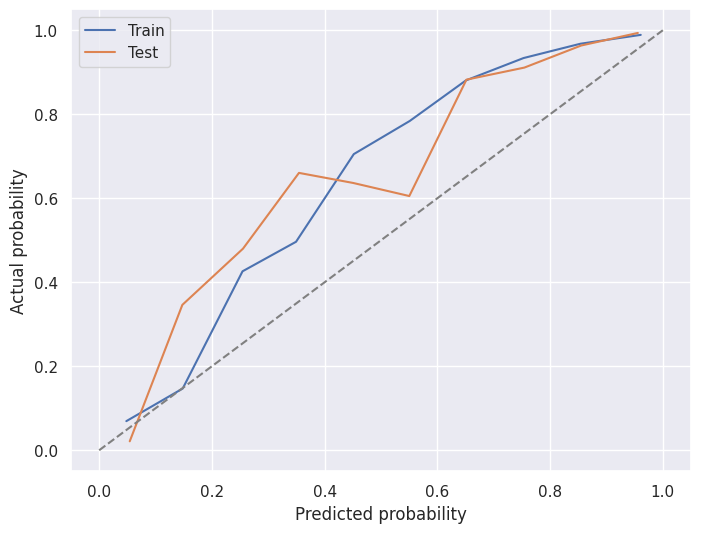

ValueError: y_prob contains values greater than 1.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

params = {'num_leaves': 41, 'max_depth': 0, 'learning_rate': 0.0222, 'n_estimators': 796,
          'subsample': 0.2939, 'colsample_bytree': 0.2796, 'reg_alpha': 0.0873, 'reg_lambda': 0.000123}
dtrain = lgb.Dataset(x_train, label=y_train)
model = lgb.train(params, dtrain)

y_train_pred = model.predict(x_train, num_iteration=model.best_iteration)
y_test_pred = model.predict(x_test, num_iteration=model.best_iteration)

bins = np.linspace(0, 1, 11)
train_calibration_data = pd.DataFrame({'predicted_probability': y_train_pred, 'actual_class': y_train})
train_calibration_data['bin'] = pd.cut(train_calibration_data['predicted_probability'], bins)
train_calibration_data = train_calibration_data.groupby('bin').agg({'predicted_probability': 'mean', 'actual_class': 'mean'})
train_calibration_data.reset_index(inplace=True)

test_calibration_data = pd.DataFrame({'predicted_probability': y_test_pred, 'actual_class': y_test})
test_calibration_data['bin'] = pd.cut(test_calibration_data['predicted_probability'], bins)
test_calibration_data = test_calibration_data.groupby('bin').agg({'predicted_probability': 'mean', 'actual_class': 'mean'})
test_calibration_data.reset_index(inplace=True)

plt.figure(figsize=(8, 6))
plt.plot(train_calibration_data['predicted_probability'], train_calibration_data['actual_class'], label='Train')
plt.plot(test_calibration_data['predicted_probability'], test_calibration_data['actual_class'], label='Test')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('Actual probability')
plt.legend()
plt.show()

train_brier_score = brier_score_loss(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred)
test_brier_score = brier_score_loss(y_test, y_test_pred)
test_log_loss = log_loss(y_test, y_test_pred)

print('Brier score for train data: {:.4f}'.format(train_brier_score))
print('Brier score for test data: {:.4f}'.format(test_brier_score))
print('Log loss for train data: {:.4f}'.format(train_log_loss))
print('Log loss for test data: {:.4f}'.format(test_log_loss))

lr_model = LogisticRegression(random_state=42)
lr_model.fit(x_train, y_train)

lr_y_train_pred = lr_model.predict_proba(x_train)[:, 1]
lr_y_test_pred = lr_model.predict_proba(x_test)[:, 1]

lr_train_calibration_data = pd.DataFrame({'predicted_probability': lr_y_train_pred, 'actual_class': y_train})
lr_train_calibration_data['bin'] = pd.cut(lr_train_calibration_data['predicted_probability'], bins)
lr_train_calibration_data = lr_train_calibration_data.groupby('bin').agg({'predicted_probability': 'mean', 'actual_class': 'mean'})
lr_train_calibration_data.reset_index(inplace=True)

lr_test_calibration_data = pd.DataFrame({'predicted_probability': lr_y_test_pred, 'actual_class': y_test})
lr_test_calibration_data['bin'] = pd.cut(lr_test_calibration_data['predicted_probability'], bins)
lr_test_calibration_data = lr_test_calibration_data.groupby('bin').agg({'predicted_probability': 'mean', 'actual_class': 'mean'})
lr_test_calibration_data.reset_index(inplace=True)

plt.figure(figsize=(8, 6))
plt.plot(lr_train_calibration_data['predicted_probability'], lr_train_calibration_data['actual_class'], label='Train')
plt.plot(lr_test_calibration_data['predicted_probability'], lr_test_calibration_data['actual_class'], label='Test')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('Actual probability')
plt.legend()
plt.show()

lr_train_brier_score = brier_score_loss(y_train, lr_y_train_pred)
lr_train_log_loss = log_loss(y_train, lr_y_train_pred)
lr_test_brier_score = brier_score_loss(y_test, lr_y_test_pred)
lr_test_log_loss = log_loss(y_test, lr_y_test_pred)

print('Brier score for logistic regression train data: {:.4f}'.format(lr_train_brier_score))
print('Brier score for logistic regression test data: {:.4f}'.format(lr_test_brier_score))
print('Log loss for logistic regression train data: {:.4f}'.format(lr_train_log_loss))
print('Log loss for logistic regression test data: {:.4f}'.format(lr_test_log_loss))


Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

In [ ]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [ ]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [21]:
gbdt_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 41,
    'max_depth': 0,
    'learning_rate': 0.02221522556208247,
    'n_estimators': 796,
    'subsample': 0.2939360477651285,
    'colsample_bytree': 0.27961182180484784,
    'reg_alpha': 0.08730110961701532,
    'reg_lambda': 0.00012315305712370508,
}
dtrain = lgb.Dataset(x_train, label=y_train)
gbdt_model = lgb.train(params=gbdt_params, train_set=dtrain)

x_test_predictions_gbdt = gbdt_model.predict(x_test, num_iteration=gbdt_model.best_iteration)

gbdt_test_score = roc_auc_score(y_test, x_test_predictions_gbdt)
print('GBDT test score:', gbdt_test_score)

[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [22]:
logreg_model = LogisticRegression().fit(x_train, y_train)

x_test_predictions_logreg = logreg_model.predict_proba(x_test)[:, 1]

logreg_test_score = roc_auc_score(y_test, x_test_predictions_logreg)
print('Logistic regression test score:', logreg_test_score)

Logistic regression test score: 0.9622150267521845


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

gbdt_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 41,
    'max_depth': 0,
    'learning_rate': 0.02221522556208247,
    'n_estimators': 796,
    'subsample': 0.2939360477651285,
    'colsample_bytree': 0.27961182180484784,
    'reg_alpha': 0.08730110961701532,
    'reg_lambda': 0.00012315305712370508,
}
dtrain = lgb.Dataset(x_train, label=y_train)
gbdt_model = lgb.train(params=gbdt_params, train_set=dtrain)

logreg_model = LogisticRegression().fit(x_train, y_train)

x_test_predictions_gbdt = gbdt_model.predict(x_test, num_iteration=gbdt_model.best_iteration)
x_test_predictions_logreg = logreg_model.predict_proba(x_test)[:, 1]

x_test_predictions_blended = (x_test_predictions_gbdt + x_test_predictions_logreg) / 2

blended_score = roc_auc_score(y_test, x_test_predictions_blended)
print('Blended score:', blended_score)

[LightGBM] [Info] Number of positive: 12315, number of negative: 6510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654183 -> initscore=0.637479
[LightGBM] [Info] Start training from score 0.637479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Качество осталось примерно то же)

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [26]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.0 MB/s eta 0:00:00


In [27]:
import catboost as cb

catboost_model = cb.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
)
catboost_model.fit(x_train, y_train)

x_test_predictions_catboost = catboost_model.predict_proba(x_test)[:, 1]

catboost_test_score = roc_auc_score(y_test, x_test_predictions_catboost)
print('CatBoost test score:', catboost_test_score)

0:	learn: 0.5838609	total: 54.6ms	remaining: 54.6s
1:	learn: 0.5141874	total: 62.5ms	remaining: 31.2s
2:	learn: 0.4593070	total: 69.5ms	remaining: 23.1s
3:	learn: 0.4152289	total: 76.6ms	remaining: 19.1s
4:	learn: 0.3870901	total: 83.8ms	remaining: 16.7s
5:	learn: 0.3656529	total: 91.5ms	remaining: 15.2s
6:	learn: 0.3486307	total: 98.8ms	remaining: 14s
7:	learn: 0.3323187	total: 107ms	remaining: 13.3s
8:	learn: 0.3226805	total: 115ms	remaining: 12.7s
9:	learn: 0.3127268	total: 123ms	remaining: 12.2s
10:	learn: 0.3059064	total: 133ms	remaining: 11.9s
11:	learn: 0.2982197	total: 141ms	remaining: 11.6s
12:	learn: 0.2936776	total: 157ms	remaining: 11.9s
13:	learn: 0.2884779	total: 168ms	remaining: 11.8s
14:	learn: 0.2843038	total: 179ms	remaining: 11.8s
15:	learn: 0.2801506	total: 188ms	remaining: 11.5s
16:	learn: 0.2777091	total: 197ms	remaining: 11.4s
17:	learn: 0.2751391	total: 206ms	remaining: 11.2s
18:	learn: 0.2729856	total: 214ms	remaining: 11s
19:	learn: 0.2704049	total: 223ms	rema

Ухудшилось))

Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
